In [1]:
import pandas as pd
import numpy as np

## Step 1 - Extract Case study

In [2]:
import urllib.request
import nltk

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'


URL = "https://www.cell.com/ajhg/fulltext/S0002-9297(17)30459-7"
#cookies = {'required_cookie': required_value}
headers={'User-Agent':user_agent,} 
cookieProcessor = urllib.request.HTTPCookieProcessor()
opener = urllib.request.build_opener(cookieProcessor)

request=urllib.request.Request(URL,None, headers) #The assembled request
response = opener.open(request,timeout=100)
data = response.read() # The data u need

In [3]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(data, "lxml")#.text

#table = soup.find('table') # what if there are more tables?

tables = soup.findAll("table")

cnt = 0
for table in tables:
    if table.findParent("table") is None:
        print(cnt)
        #print(str(table))
        cnt += 1

0


### Import Acronym list
The acronyms were expanded with respect to the following dictionary: https://www.tabers.com/tabersonline/view/Tabers-Dictionary/767492/all/Medical_Abbreviations

In [5]:
import pickle

def expand_acronyms(s, acronyms):
    for k, v in acronyms.items():
        s = s.replace(' ' + k + ' ', v)
    return s

a_file = open("preprocessing/acronym_list.pkl", "rb")
d_acronyms = pickle.load(a_file)
a_file.close()

l_del = []

## remove acronyms that only consist of a single character (too ambgious)
for key in d_acronyms.keys():
    if len(key) < 2:
        l_del.append(key)
        
def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]
    return the_dict
            
d_acronyms = entries_to_remove(l_del, d_acronyms)

## First Product: Save extracted file

### Step 1 Extract Main text

1. First make a folder for the output (if it doesnt exist already)
2. Remove all HTML artefacts (maybe capture certain flags)

In [18]:
import re
import os

for div in soup.find_all('div', {'class': 'dropBlock__body'}):  # , {'class':'Google-Scholar'}
    div.replaceWith('')

for div in soup.find_all('div', {'class': 'inline-table'}):  # , {'class':'Google-Scholar'}
    div.replaceWith('')

for element in ['ul', 'i', 'span', 'li', 'a', "script", "style", "meta", "link", "sup", "select", "option", "figcaption"]: # a 
    for div in soup.find_all(element):  # , {'class':'Google-Scholar'}
        #print(div)
        div.decompose()
        

for s in soup.select('div'):
    s.get_attribute_list = ''       

title= soup.title.string
title = title[:50].replace(' ', '_')

new_soup = re.sub(r"\<em\>|\</em\>", "", str(soup)) # remove em tags ? (overbodig?)
new_soup = re.sub(r"\<[^\>]+\>", "", new_soup) #remove html tags
new_soup = re.sub(r"\s{3,}", r'<br>', new_soup) # change excessive spaces into a single newline
new_soup = re.sub(r"\.([A-Z])", r'. \1', new_soup) # add whitespace where a new sentence is started
new_soup = re.sub(r"\n", r"<br>", new_soup) # format newlines to <br>
#new_soup = expand_acronyms(new_soup, d_acronyms)

#content = 'DOI: ' + URL + '<br><br>' + str(soup.prettify())
#with open("results/0_raw/%s.html" % (title), "w", encoding="utf-8") as file:
#    file.write(content)

new_soup = 'DOI: ' + URL + '<br><br>' + new_soup

if not os.path.exists('results/%s' % (title)) : # make new folder
    os.makedirs('results/%s' % (title)) 
    os.makedirs('results/%s/0_raw' % (title)) 
    os.makedirs('results/%s/1_extractions' % (title)) 
    os.makedirs('results/%s/2_phenotypes' % (title)) 
    os.makedirs('results/%s/3_annotations' % (title)) 

with open("results/%s/0_raw/Main_text_%s.html" % (title, title), "w", encoding="utf-8") as file:
    file.write(new_soup)

In [166]:
soup

<!DOCTYPE html>
<html class="pb-page" data-request-id="b0da0fb5-e67d-4f70-a994-8bb2c1337e9f" lang="en"><head data-pb-dropzone="head">
<!-- if there is any customization for Responsive Project widget  -->













<title>ACTB Loss-of-Function Mutations Result in a Pleiotropic Developmental Disorder: The American Journal of Human Genetics</title>                                                                                                                                                 <!--

    Pagebuild admin UI
-->
<noscript>

</noscript>



<input name="journalCode-ux3-lastin-head" type="hidden" value="ajhg"/>


<!-- -->

</head>
<body class="pb-ui">
<div class="skip">

</div>


<div data-ng-non-bindable="" id="pb-page-content">
<div data-pb-dropzone="main" data-pb-dropzone-name="Main">
<div class="ux3" data-widget-def="ux3-layout-widget" data-widget-id="832ad3f3-97ac-45ab-9af1-90c6f7bff54a">
<div class="ajhg">
<div data-widget-id="832ad3f3-97ac-45ab-9af1-90c6f7bff54a" data-wid

### Step 2 - Extract Table

In [19]:
def tableDataText(table):    
    """Parses a html segment started with tag <table> followed 
    by multiple <tr> (table rows) and inner <td> (table data) tags. 
    It returns a list of rows with inner columns. 
    Accepts only one <th> (table header/data) in the first row.
    """
    def rowgetDataText(tr, coltag='td'): # td (data) or th (header)       
        return [td.get_text(strip=True) for td in tr.find_all(coltag)]  
    rows = []
    trs = table.find_all('tr')
    headerow = rowgetDataText(trs[0], 'th')
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append(rowgetDataText(tr, 'td') ) # data row       
    return rows

def parseTable(table, remove_inc=True):
    """
    Convert Table to pandas Dataframe
    
    Input:
        table = html table from article
        remove_inc = remove rows with incosistent length
            (be careful: these can be helpful to categorize table)
    """
    list_table = tableDataText(table)
    dftable = pd.DataFrame(list_table[1:], columns=list_table[0])
    if remove_inc:
        med = np.median(dftable.isnull().sum(axis=1).values)
        dftable = dftable.dropna(thresh=len(dftable.columns)-med)
    return dftable

# Save all tables independently
index = 0
for table in tables:
    raw_table = parseTable(table)
    raw_table.to_csv("results/%s/0_raw/Table_%s_%s.csv" % (title, str(index), title), sep='|', index=False)
    index += 1

### Read Table

In [20]:
index = 0
table0 = pd.read_csv("results/%s/0_raw/Table_%s_%s.csv" % (title, str(index), title), sep='|')
table0.head()

,Case ID,Inheritance,Gender,Age (Years),Prenatal and Neonatal History,PN Growth Retardation,Microcephaly,Motor Delay,Speech Delay,DD/ ID,"Behavioral, Psychiatric, and Neurological Features",Malformations and Physical Anomalies,Additional Comments
0,I,DN,M,4,SGA and feeding difficulties,Y,N,Y,Y,mod,possible absence and focal seizures,"VSD with tortuous aortic arch, horseshoe kidne...","early-onset hypothyroidism, limitation of join..."
1,II,DN,M,7,SGA and feeding difficulties,Y,N,Y,Y,mild,"sociable, empathetic, hand flapping tendency a...","Rt pelvic kidney, Rt inguinal hernia and scoli...","GOR, asthma and allergies."
2,III,DN,M,7,"SGA, polycythaemia, jaundice and hypoglycaemia...",Y,Y,N,Y,Mild,"attention deficit, echolalia and tantrums.","inguinal hernia, cryptorchidism, proximally pl...","perineal and scalp abscesses, recurrent chest ..."
3,IVa,Mat,F,32,SGA,Y,N,Y,Y,mod,empathetic personality.,scoliosis,"glaucoma, asthma, and eczema"
4,IVb,U,F,68,U,U,U,U,U,mild,U,horseshoe kidney with multiple cysts,hiatus hernia


### Second Product: Extract text where phenotypes are mentioned (not right/ left things like that)

Perform low resolution Clinphen to check locations of phenotypes. (Without typo correction)
- extensive = ?? sec (>5 min)
- quick ( without typo) 1.7 sec

In [143]:
from clinphen_src import get_phenotypes
from clinphen_src import src_dir
import importlib as imp
imp.reload(get_phenotypes)

def load_common_phenotypes(commonFile):
    returnSet = set()
    for line in open(commonFile): returnSet.add(line.strip())
    return returnSet

def clinphen(inputFile, srcDir, extensive=True, custom_thesaurus="", rare=False):
    """
    Employ ClinPhen to infer HPO-codes based on format-free text 
    
    first_intercept = First intercepted phenotypes (from a simple Screening)
    
    Extensive: perform an extensive search
    """
    #srcDir
    print(extensive)
    hpo_main_names = srcDir + "/hpo_term_names.txt"

    def getNames():
        returnMap = {}
        for line in open(hpo_main_names):
            lineData = line.strip().split("\t")
            returnMap[lineData[0]] = lineData[1]
        return returnMap
    hpo_to_name = getNames()

    inputStr = ""
    for line in open(inputFile): inputStr += line
    if extensive:
        if not custom_thesaurus: returnString = get_phenotypes.extract_phenotypes(inputStr, hpo_to_name, extensive)
        else: returnString = get_phenotypes.extract_phenotypes_custom_thesaurus(inputStr, custom_thesaurus, hpo_to_name)
        if not rare: return returnString
    else:
        if not custom_thesaurus: returnString, first_intercept, lines = get_phenotypes.extract_phenotypes(inputStr, hpo_to_name, extensive)
        else: returnString = get_phenotypes.extract_phenotypes_custom_thesaurus(inputStr, custom_thesaurus, hpo_to_name)
        if not rare: return returnString, first_intercept, lines
    #print('qq')
    items = returnString.split("\n")
    returnList = []
    common = load_common_phenotypes(srcDir + "/common_phenotypes.txt")
    for item in items:
        HPO = item.split("\t")[0]
        if HPO in common: continue
        returnList.append(item)
    if extensive == True:
        return "\n".join(returnList)
    elif extensive == False :
        return "\n".join(returnList), first_intercept, lines
    
def clinphen_str(inputStr, srcDir, extensive=True, custom_thesaurus="", rare=False):
    """
    Employ ClinPhen to infer HPO-codes based on format-free text 
    
    first_intercept = First intercepted phenotypes (from a simple Screening)
    
    Extensive: perform an extensive search
    
    
    """
    #srcDir
    print(extensive)
    hpo_main_names = srcDir + "/hpo_term_names.txt"

    def getNames():
        returnMap = {}
        for line in open(hpo_main_names):
            lineData = line.strip().split("\t")
            returnMap[lineData[0]] = lineData[1]
        return returnMap
    hpo_to_name = getNames()

    if extensive:
        if not custom_thesaurus: returnString = get_phenotypes.extract_phenotypes(inputStr, hpo_to_name, extensive)
        else: returnString = get_phenotypes.extract_phenotypes_custom_thesaurus(inputStr, custom_thesaurus, hpo_to_name)
        if not rare: return returnString
    else:
        if not custom_thesaurus: returnString, first_intercept, lines = get_phenotypes.extract_phenotypes(inputStr, hpo_to_name, extensive)
        else: returnString = get_phenotypes.extract_phenotypes_custom_thesaurus(inputStr, custom_thesaurus, hpo_to_name)
        if not rare: return returnString, first_intercept, lines
    #print('qq')
    items = returnString.split("\n")
    returnList = []
    common = load_common_phenotypes(srcDir + "/common_phenotypes.txt")
    for item in items:
        HPO = item.split("\t")[0]
        if HPO in common: continue
        returnList.append(item)
    if extensive == True:
        return "\n".join(returnList)
    elif extensive == False :
        return "\n".join(returnList), first_intercept, lines

C:\Users\levrex\Anaconda3\envs\my_env\lib\site-packages\clinphen_src\data\hpo_synonyms.txt


## Perform first screening on Article 

- get first interceptions 

In [310]:
import time
start = time.time()
print("Time elapsed on working...")

items, first_intercept, lines = clinphen('results/%s/0_raw/Main_text_%s.html' % (title, title),'data', extensive=False)

end = time.time()
print("Time consumed in working: ",end - start)

df_hpo = pd.DataFrame([n.split('\t') for n in items.split('\n')])
df_hpo.columns = df_hpo.iloc[0]
df_hpo = df_hpo.reindex(df_hpo.index.drop(0))
df_hpo.to_csv('results/%s/2_phenotypes/%s.csv' % (title, title))
df_hpo.head()

Time elapsed on working...
False
Time consumed in working:  2.1433944702148438


,HPO ID,Phenotype name,No. occurrences,Earliness (lower = earlier),Example sentence
1,HP:0001249,Intellectual disability,12,6,all individuals in our cohort displayed develo...
2,HP:0000154,Wide mouth,10,25,this is distinct from the typical facial dysmo...
3,HP:0000118,Phenotypic abnormality,8,18,collectively our data show that internal organ...
4,HP:0001263,Global developmental delay,6,16,all individuals in our cohort displayed develo...
5,HP:0001627,Abnormal heart morphology,6,18,congenital cardiac anomalies such as ventricul...


### 1st product - Relevant text

ToDo: think about where you place the border

In [311]:
1 % 10 

1

### Reading Frame screening

In [316]:
import numpy as np

BIN_SIZE = 10
MIN_POWER = 3

parsed_list = [item for sublist in lines for item in sublist] # get parsed text

bin_ix = 0
bin_phenotypes = []
bin_sum = 0

reading_frames = {0: 0, 1:0, 2:0, 3:0, 4:0} #[0, 1, 2, 3, 4]
d_phenotype = {}

txt = ''
start_str = '<span style="color:red">'
end_str = '</span>'

for frame in reading_frames: # initialize
    d_phenotype[frame] = [0]
    
for ix, sent in enumerate(parsed_list): 
    if ix in first_intercept:
        txt += ' ' + start_str + parsed_list[ix] + end_str + ' ' 
        for frame in reading_frames.keys():
            frame_ix = reading_frames[frame]
            val = d_phenotype[frame][frame_ix]
            d_phenotype[frame][frame_ix] = val + first_intercept.count(ix)
        bin_sum += first_intercept.count(ix)
    else :
        txt += parsed_list[ix] + ' '
    for frame in reading_frames.keys():
        frame_ix = reading_frames[frame]
        if (ix+1+frame) % BIN_SIZE == 0 :
            l_values = d_phenotype[frame]
            l_values.append(0)
            d_phenotype[frame] = l_values 
            reading_frames[frame] += 1
    if (ix+1) % BIN_SIZE == 0 : # +1 -> because python begins with counting from 0
        bin_phenotypes.append(bin_sum)
        bin_sum = 0
        bin_ix += 1
bin_phenotypes.append(bin_sum)
for frame in reading_frames.keys():
    frame_ix = reading_frames[frame]
    if (ix+1+frame) % BIN_SIZE == 0 :
        l_values = d_phenotype[frame]
        l_values.append(0)
        d_phenotype[frame] = l_values 
        reading_frames[frame] += 1
#print(reading_frames)


with open("results/%s/1_extractions/Annotated_%s.html" % (title, title), "w", encoding="utf-8") as file:
    file.write(txt)

In [317]:
reading_frames = {0: 0, 1:0, 2:0, 3:0, 4:0}

bin_ix = 0
txt = ''
start_str = '<span style="color:red">'
end_str = '</span>'
for ix, sent in enumerate(parsed_list): 
    passing = False
    for frame in reading_frames.keys():
        frame_ix = reading_frames[frame]
        if d_phenotype[frame][frame_ix] > MIN_POWER:
            passing = True 
    if passing== 1:
        txt += ' ' + start_str + parsed_list[ix] + end_str + ' ' 
    else :
        txt += parsed_list[ix] + ' '
    for frame in reading_frames.keys():
        frame_ix = reading_frames[frame]
        if (ix+1+frame) % BIN_SIZE == 0 :
            reading_frames[frame] += 1

with open("results/%s/1_extractions/Annotated_%s.html" % (title, title), "w", encoding="utf-8") as file:
    file.write(txt)

In [228]:
bin_ix = 0
txt = ''
start_str = '<span style="color:red">'
end_str = '</span>'
for ix, sent in enumerate(parsed_list): 
    #print(bin_ix)
    if bin_phenotypes[bin_ix] > 5:
    # ix in sorted({x for v in mr_map.values() for x in v}) or ix in df_hpo['Earliness (lower = earlier)'].astype(int).unique()
        #print('y')
        txt += ' ' + start_str + parsed_list[ix] + end_str + ' ' 
    else :
        txt += parsed_list[ix] + ' '
    if (ix+1) % BIN_SIZE == 0:
        bin_ix += 1

with open("results/%s/1_extractions/Annotated_%s.html" % (title, title), "w", encoding="utf-8") as file:
    file.write(txt)

In [286]:
bin_phenotypes[bin_ix]

0

In [285]:
d_phenotype[0]

[9,
 8,
 8,
 0,
 2,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 7,
 8,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 5,
 15,
 10,
 9,
 26,
 15,
 18,
 2,
 0,
 12,
 2,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0]

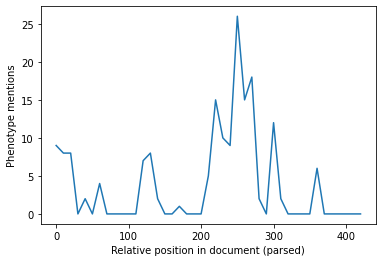

In [300]:
import matplotlib.pyplot as plt



plt.plot( [i* BIN_SIZE for i in range(len(d_phenotype[0])) ], list(d_phenotype[0]))
plt.ylabel('Phenotype mentions')
plt.xlabel('Relative position in document (parsed)')
plt.show()

## Step 3 ClinPhen 

In [21]:
items = clinphen('example_data.txt','data', extensive=True)

df_hpo = pd.DataFrame([n.split('\t') for n in items.split('\n')])
df_hpo.columns = df_hpo.iloc[0]
df_hpo = df_hpo.reindex(df_hpo.index.drop(0))
df_hpo.head()

True


,HPO ID,Phenotype name,No. occurrences,Earliness (lower = earlier),Example sentence
1,HP:0000006,Autosomal dominant inheritance,1,0,townes brocks syndrome tbs is an autosomal dom...
2,HP:0000356,Abnormality of the outer ear,1,2,major findings include external ear anomalies ...
3,HP:0000598,Abnormality of the ear,1,2,major findings include external ear anomalies ...
4,HP:0000365,Hearing impairment,1,3,major findings include external ear anomalies ...
5,HP:0010442,Polydactyly,1,4,major findings include external ear anomalies ...


## Check header table - TODO

In [36]:
raw_table.apply(lambda x : clinphen_str(' '.join(x),'data', extensive=True)) # TODODOODOD

True
True
True
True
True
True
True
True
True
True
True
True
True


TypeError: sequence item 0: expected str instance, list found

In [27]:
l_yes = ['y', 'true', 't', 'yes', '1', 'present', 'p', 'pres'] 
l_no = ['n', 'false', 'f', 'no', '0', 'absent', 'a', 'abs']
l_unknown = ['u', 'unknown', 'na', 'nan'] # , ''


#if all values within at least one of the lists above

In [29]:
l_not = []
for col in raw_table.columns:
    l_val = raw_table[col].values
    for i in l_val:
        #print(i)
        val = i.lower()
        if (val not in l_yes and val not in l_no and val not in l_unknown):
            l_not.append(col)
            break
#print(l_not)
l_qualify = list(set(raw_table.columns) - set(l_not))
l_qualify
#np.all([i if (i in l_yes or i in l_no) for i in ])

['Motor Delay', 'Microcephaly', 'PN Growth Retardation', 'Speech Delay']

In [30]:
d_col = {}

for col in l_qualify:
    l_hpo = [] 
    with open('screen_text.txt', 'w') as f:
        f.write(col)
    items = clinphen('screen_text.txt','data')
    df_hpo = pd.DataFrame([n.split('\t') for n in items.split('\n')])
    df_hpo.columns = df_hpo.iloc[0]
    df_hpo = df_hpo.reindex(df_hpo.index.drop(0))
    d_col[col] = list(df_hpo['HPO ID'])

True
True
True
True


In [31]:
d_col

{'Motor Delay': ['HP:0001270'],
 'Microcephaly': ['HP:0000252', 'HP:0011451'],
 'PN Growth Retardation': ['HP:0001510'],
 'Speech Delay': ['HP:0000750']}

In [32]:
def col_hpo(row, d_col):
    #print(row)
    l_hpo = []
    for ix, i in enumerate(row):
        #print(ix)
        col_name = row.keys()[ix]
        val = i.lower()
        if val in l_yes:
            l_hpo.extend(d_col[col_name])
    return l_hpo
raw_table['col_hpo'] = raw_table.apply(lambda x : col_hpo(x, d_col), axis=1)

In [33]:
raw_table

,Case ID,Inheritance,Gender,Age (Years),Prenatal and Neonatal History,PN Growth Retardation,Microcephaly,Motor Delay,Speech Delay,DD/ ID,"Behavioral, Psychiatric, and Neurological Features",Malformations and Physical Anomalies,Additional Comments,col_hpo
1,I,DN,M,4,SGA and feeding difficulties,Y,N,Y,Y,mod,possible absence and focal seizures,"VSD with tortuous aortic arch, horseshoe kidne...","early-onset hypothyroidism, limitation of join...","[HP:0001510, HP:0001270, HP:0000750]"
2,II,DN,M,7,SGA and feeding difficulties,Y,N,Y,Y,mild,"sociable, empathetic, hand flapping tendency a...","Rt pelvic kidney, Rt inguinal hernia and scoli...","GOR, asthma and allergies.","[HP:0001510, HP:0001270, HP:0000750]"
3,III,DN,M,7,"SGA, polycythaemia, jaundice and hypoglycaemia...",Y,Y,N,Y,Mild,"attention deficit, echolalia and tantrums.","inguinal hernia, cryptorchidism, proximally pl...","perineal and scalp abscesses, recurrent chest ...","[HP:0001510, HP:0000252, HP:0011451, HP:0000750]"
4,IVa,Mat,F,32,SGA,Y,N,Y,Y,mod,empathetic personality.,scoliosis,"glaucoma, asthma, and eczema","[HP:0001510, HP:0001270, HP:0000750]"
5,IVb,U,F,68,U,U,U,U,U,mild,U,horseshoe kidney with multiple cysts,hiatus hernia,[]
7,V,DN,F,13,SGA and feeding difficulties,Y,N,Y,Y,mod,"sociable personality, mild ventriculomegaly, a...","VSD, PDA, BL 5th finger clinodactyly, BL 2-3 &...",N,"[HP:0001510, HP:0001270, HP:0000750]"
8,VI,U,M,20,N,Y,N,N,Y,mild,stress intolerance.,"short and broad uvula, broad halluces, short d...","frequent otisis media, GH deficiency and limit...","[HP:0001510, HP:0000750]"
9,VII,DN,F,12,"SGA, hypotonia and feeding difficulties",Y,Y,Y,Y,mod,emotional problems and hypotonia,"tricuspid valve dysplasia, 2-3-4 fingers and 2...",BL severe SNHL and dorsal hypertrichosis,"[HP:0001510, HP:0000252, HP:0011451, HP:000127..."
10,VIII,DN,M,7,"SGA, hypotonia and feeding difficulties",Y,N,Y,Y,sev,"Thin CC, septum pellucidum cyst, megacisterna ...","BL CLAP, VSD, Lt extra nipple, hypospadias, UL...",cutis marmorata; additionalde novo1.65 Mb loss...,"[HP:0001510, HP:0001270, HP:0000750]"
11,IX,DN,M,6,hypotonia and feeding difficulties,Y,Y,Y,Y,mod,cortical and subcortical atrophy,atrial septal defect and BL inguinal hernia,GOR,"[HP:0001510, HP:0000252, HP:0011451, HP:000127..."


In [40]:
raw_table.iloc[9]['col_hpo']

['HP:0001510', 'HP:0000252', 'HP:0011451', 'HP:0001270', 'HP:0000750']